In [2]:
from libsvm.python.libsvm.svmutil import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
tmp = [65, 34, 72, 80, 52, 47, 90, 42, 76]
tmp = np.array(tmp)
a = np.sqrt(tmp.std()*tmp.std()*9/8)
print(a)

19.111514853616395


In [26]:
y, x = svm_read_problem('train.txt')
yt, xt = svm_read_problem('test.txt')

x_train = [list(t.values()) for t in x]
y_train = [t for t in y]
x_test = [list(t.values() )for t in xt]
y_test = [t for t in yt]

x_train = np.array(x_train)
y_train = np.array(y_train).reshape(-1,1)
x_test = np.array(x_test)
y_test = np.array(y_test)

data = np.concatenate((x_train, y_train), axis=1)

# Q9

In [27]:
class DecisionTree:
    def __init__(self):
        self.tree = None

    def get_impurity(self, labels):
        if len(labels) == 0:
            return 0 
        # use mean squared error
        mode = np.mean(labels)
        impurity = np.sum((labels - mode) ** 2)
        return impurity
    
    def find_best_split(self, data, feature_index):

        feature_values = sorted(data[:, feature_index])
        best_theta = 0.0
        thetas = [feature_values[0] - 1]
        
        # get thetas
        for i in range(len(feature_values) - 1):
            if feature_values[i] == feature_values[i + 1]:
                continue
            theta = 0.5 * (feature_values[i] + feature_values[i + 1])
            thetas.append(theta)
        thetas.append(feature_values[-1] + 1)
        # find best theta
        best_impurity = float('inf')
        for theta in thetas:
            left_data = data[data[:, feature_index] <= theta]
            right_data = data[data[:, feature_index] > theta]
            impurity = self.get_impurity(left_data[:, -1]) + self.get_impurity(right_data[:, -1])

            if impurity < best_impurity:
                best_impurity = impurity
                best_theta = theta

        return feature_index, best_theta, best_impurity

    def fit(self, data):
        self.tree = self._build_tree(data)

    def _build_tree(self, data):
        if len(set(data[:, -1])) == 1:
            # All labels are the same, create a leaf node
            return {'value': data[0, -1]}
        
        num_features = data.shape[1] - 1
        best_split = None
        best_impurity = float('inf')
        feature_index = None

        for i in range(num_features):
            feature_index, theta, impurity = self.find_best_split(data, i)
            if impurity < best_impurity:
                best_impurity = impurity
                best_split = (feature_index, theta)

        if best_split is None:
            # No split improves impurity, create a leaf node
            return {'value': np.mean(data[:, -1])}

        feature_index, theta = best_split
        left_data = data[data[:, feature_index] <= theta]
        right_data = data[data[:, feature_index] > theta]
        # print(left_data.shape, right_data.shape)
        return {
            'feature_index': feature_index,
            'theta': theta,
            'left': self._build_tree(left_data),
            'right': self._build_tree(right_data)
        }

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            predictions[i] = self._predict_one(self.tree, X[i])
        return predictions

    def _predict_one(self, node, x):
        if 'value' in node:
            return node['value']
        elif x[node['feature_index']] <= node['theta']:
            return self._predict_one(node['left'], x)
        else:
            return self._predict_one(node['right'], x)

tree_model = DecisionTree()
tree_model.fit(data)

In [28]:
# test
y, x = svm_read_problem('test.txt')
x_test = np.array([list(t.values()) for t in x])
y_test = np.array(y)
y_pred = tree_model.predict(x_test)

y_pred = np.array(y_pred).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

# get error of prediction
error = np.sum((y_test - y_pred) ** 2 / len(y_test))
print(error)

8.79324462640737


# Q10

In [29]:
def bagging_random_forest(data, num_trees):
    trees = []
    e_out_values = []

    for _ in range(num_trees):

        # Sample with replacement
        sampled_data = data[np.random.choice(data.shape[0], size=int(data.shape[0]/2), replace=True)]

        # Create and fit a decision tree on the sampled data
        tree_model = DecisionTree()
        tree_model.fit(sampled_data)


        # get eout
        predictions = tree_model.predict(x_test)
        e_out = np.mean((predictions - y_test.flatten())**2)
        e_out_values.append(e_out)

        trees.append(tree_model)
        if _ % 100 == 0:
            print(_)

    return trees, e_out_values

# Number of trees in the random forest
num_trees = 2000

# Perform bagging with random forest
random_forest_trees, e_out_values = bagging_random_forest(data, num_trees)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


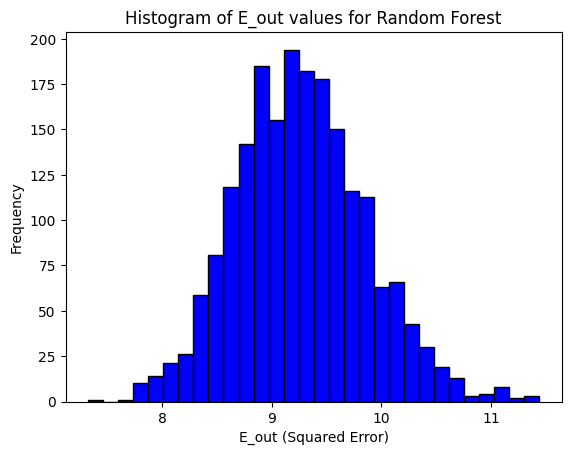

In [30]:
# Plot a histogram of E_out values
plt.hist(e_out_values, bins=30, color='blue', edgecolor='black')
plt.xlabel('E_out (Squared Error)')
plt.ylabel('Frequency')
plt.title('Histogram of E_out values for Random Forest')
plt.show()

# Q11

In [31]:
def Gx_random_forest(X, trees):
    predictions = []
    for t in trees:
        predictions.append(t.predict(X))
    predictions = np.array(predictions)
    predictions = np.mean(predictions, axis=0)
    return predictions

e_out_gt = e_out_values
e_in_gt = []
e_in_Gt = []
e_out_Gt = []

for i in range(1, num_trees + 1):
    y_pred =random_forest_trees[i-1].predict(x_train)
    e_in_gt.append(np.mean((y_train.flatten() - y_pred.flatten())**2))
    
e_in_Gt.append(np.mean((y_train.flatten() - Gx_random_forest(x_train, random_forest_trees))**2))
e_out_Gt.append(np.mean((y_test.flatten() - Gx_random_forest(x_test, random_forest_trees))**2))

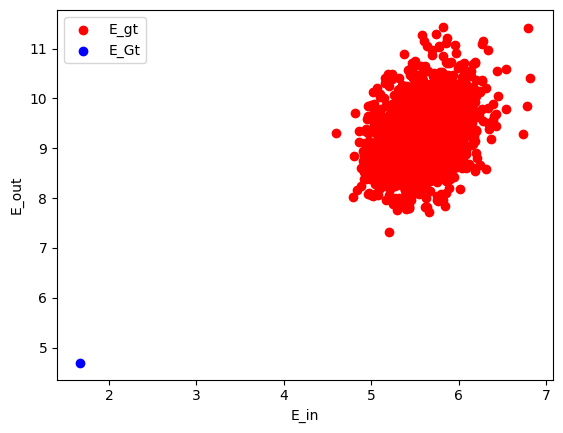

In [32]:
# plot scatter plot (e_in_gt, e_out_gt) and (e_in_Gt, e_out_Gt)
plt.scatter(e_in_gt, e_out_gt, label='E_gt', color = 'red')
plt.scatter(e_in_Gt, e_out_Gt, label='E_Gt', color = 'blue')
plt.xlabel('E_in')
plt.ylabel('E_out')
plt.legend()

We can see through getting the avg of our random forest, we can significantly let E_out and E_in to drop.

The E_in dropped from 6 to less than 2, and E_out dropped from 10 to less than 5.

The E_out basicly become the half of those RF.

We can conclude that those RF trained by random sampling are pretty different, so that Eout can be reduce that much.

# Q12

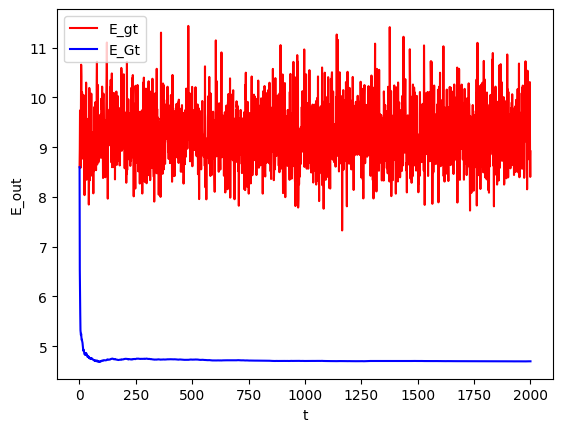

In [33]:
E_out_Gt = []
tree_predictions = []
T = [t for t in range(1, num_trees + 1)]
for t in random_forest_trees:
    y_pred = t.predict(x_test)
    tree_predictions.append(y_pred)


for t in range(1,len(random_forest_trees)+1):
    predictions = tree_predictions[:t]
    mean_pred = np.mean(predictions, axis=0)
    E_out_Gt.append(np.mean((y_test.flatten() - mean_pred)**2))


# Plot the Eout(gt) as a function of t, and plot Eout(Gt) as a function of t on the same figure
plt.plot(T, e_out_gt, label='E_gt', color = 'red')
plt.plot(T, E_out_Gt, label='E_Gt', color = 'blue')
plt.xlabel('t')
plt.ylabel('E_out')
plt.legend()

As we can see, we don't really need 2000 trees to achieve this amazing performance.

Less than 100 trees would've already do the work.

We can see that the difference for 100 trees are already sufficiently enough.

With more trees, the value only goes towards convergence, which is not a lot of improvement.

If we trained with only 100 trees, we could've save a lot time and achieve almost the same performance.